# Explore AIMed Dataset


In [1]:
aimed_bioc = "http://corpora.informatik.hu-berlin.de/corpora/brat2bioc/aimed_bioc.xml.zip"
xml_file_name = "aimed_bioc.xml"

In [ ]:
!wget $aimed_bioc
!unzip aimed_bioc.xml.zip

In [2]:
import sys
sys.path.append('./source')

#### Covert to pandas json

In [3]:
from datatransformer.BiocToDataFrame import BiocToDataFrame
df = BiocToDataFrame().parse(xml_file_name)


In [4]:
df.head(n=10)

,docid,isValid,participant1,participant2,passage
0,AIMed_d30,False,PS1,presenilin (PS) 1,Isolation of human delta-catenin and its bindi...
1,AIMed_d30,False,armadillo-protein,presenilin (PS) 1,Isolation of human delta-catenin and its bindi...
2,AIMed_d30,False,p0071,presenilin (PS) 1,Isolation of human delta-catenin and its bindi...
3,AIMed_d30,False,PS2,presenilin (PS) 1,Isolation of human delta-catenin and its bindi...
4,AIMed_d30,False,PS-2,presenilin (PS) 1,Isolation of human delta-catenin and its bindi...
5,AIMed_d30,False,presenilin (PS) 1,presenilin 1,Isolation of human delta-catenin and its bindi...
6,AIMed_d30,True,delta-catenin,presenilin (PS) 1,Isolation of human delta-catenin and its bindi...
7,AIMed_d30,False,PS1,armadillo-protein,Isolation of human delta-catenin and its bindi...
8,AIMed_d30,True,PS1,p0071,Isolation of human delta-catenin and its bindi...
9,AIMed_d30,False,PS1,PS2,Isolation of human delta-catenin and its bindi...


In [21]:
df.loc[6,"passage"]

'Isolation of human delta-catenin and its binding specificity with presenilin 1.\nWe screened proteins for interaction with presenilin (PS) 1, and cloned the full-length cDNA of human delta-catenin, which encoded 1225 amino acids.\nYeast two-hybrid assay, GST binding assay and immunoprecipitation demonstrated that delta-catenin interacted with a hydrophilic loop region in the endoproteolytic C-terminal fragment of PS1, but not with that of PS-2.\nThese results suggest that PS1 and PS2 partly differ in function.\nPS1 loop fragment containing the pathogenic mutation retained the binding ability.\nWe also found another armadillo-protein, p0071, interacted with PS1.'

In [5]:
df.shape

(5522, 5)

In [50]:
unique_passages = df["passage"].unique()
unique_sentence_count=[ len(r.split("\n")) for r in unique_passages]
print("Unique setences :  " , sum(unique_sentence_count))

Unique setences :   1938


### Explore dataset

In [6]:
import matplotlib.pyplot as plt

df["isValid"].value_counts().plot.pie(autopct='%.2f',figsize=(4, 4))
plt.show()

<Figure size 400x400 with 1 Axes>

In [7]:
df["docid"].nunique()

222

## Split into train/test/validation

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

unique_docids = df.docid.unique()
stratified =  [ df.query("docid == '{}'".format(p))['isValid'].iloc[0] for p in unique_docids]
traindocid, valdocid = train_test_split(unique_docids,  test_size=.1,
                                                        random_state=777, stratify=stratified)

In [10]:

stratified =  [df.query("docid == '{}'".format(p))['isValid'].iloc[0] for p in traindocid]
traindocid, testdocid = train_test_split(traindocid,  test_size=.2,
                                                        random_state=777, stratify=stratified)

In [11]:
train = df[df['docid'].isin(traindocid)]
test = df[df['docid'].isin(traindocid)]
val = df[df['docid'].isin(traindocid)]




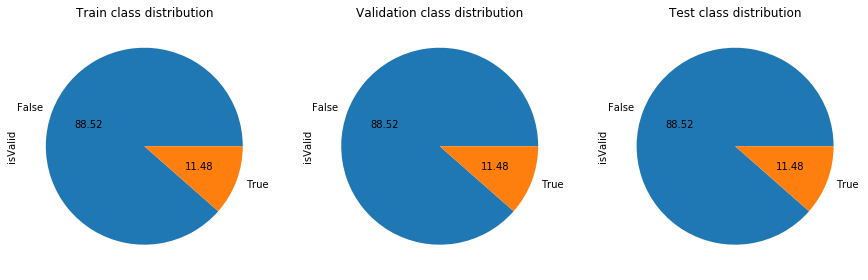

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution')
test.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])


plt.show()

In [13]:
train.to_json("AIMedtrain.json")
test.to_json("AIMedtest.json")
val.to_json("AIMedval.json")

In [20]:
train.sample(n=20).to_json("Aimedsample.json")